In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 导入数据并处理
数据导出，删去此次作业不需要处理的列，并将数值属性离散化

In [146]:
dataset1 = pd.read_csv('.\winemag-data_first150k.csv')
dataset2 = pd.read_csv('.\winemag-data-130k-v2.csv')

dataset = pd.concat([dataset1, dataset2], axis=0, join='inner')

dataset.drop(['description','designation','variety','winery','region_2'],axis=1,inplace=True)

points_qujian=[80,85,90,95,100]
price_qujian=[0,50,100,200,500,1000,5000]
dataset['points_l'] = pd.cut(dataset.points,points_qujian,right=False)
dataset['price_l'] = pd.cut(dataset.price,price_qujian,right=False)
dataset.tail(10)

,Unnamed: 0,country,points,price,province,region_1,points_l,price_l
129961,129961,Italy,90,30.0,Sicily & Sardinia,Sicilia,"[90, 95)","[0.0, 50.0)"
129962,129962,Italy,90,40.0,Sicily & Sardinia,Sicilia,"[90, 95)","[0.0, 50.0)"
129963,129963,Israel,90,20.0,Galilee,NaN,"[90, 95)","[0.0, 50.0)"
129964,129964,France,90,NaN,Alsace,Alsace,"[90, 95)",NaN
129965,129965,France,90,28.0,Alsace,Alsace,"[90, 95)","[0.0, 50.0)"
129966,129966,Germany,90,28.0,Mosel,NaN,"[90, 95)","[0.0, 50.0)"
129967,129967,US,90,75.0,Oregon,Oregon,"[90, 95)","[50.0, 100.0)"
129968,129968,France,90,30.0,Alsace,Alsace,"[90, 95)","[0.0, 50.0)"
129969,129969,France,90,32.0,Alsace,Alsace,"[90, 95)","[0.0, 50.0)"
129970,129970,France,90,21.0,Alsace,Alsace,"[90, 95)","[0.0, 50.0)"


## 找出频繁模式
最低支持度为10%找出频繁模式，并计算支持度和置信度

In [294]:
rownum = dataset.shape[0]

group = {'1':['country','points_l'],
       '2':['country','price_l'],
       '3':['points_l','price_l'],
        '4':['price_l','points_l']}
group = pd.DataFrame(group)

count1 = dataset['country'].value_counts().reset_index(name='times')
count2 = dataset['points_l'].value_counts().reset_index(name='times')
count3 = dataset['price_l'].value_counts().reset_index(name='times')
count = pd.concat([count1, count2, count3], axis=0, join='inner')

In [292]:

fp = {'X':[],
      'Y':[],
      'times':[],
      'support':[],
      'c':[]}
fp = pd.DataFrame(fp)
for index, row in group.iteritems():
    gp1=dataset.groupby(by=[row[0],row[1]])
    gp1 = gp1.size().reset_index(name='times')
    gp1['support'] = gp1['times'] / rownum * 100
    # 最低支持度为10%
    condition1 = gp1["support"] > 10
    sub = gp1[condition1]
    sub.columns=['X','Y','times','support']
    fp = pd.concat([fp,sub], axis=0, join='inner')


for index, row in fp.iterrows():
    a = row['times'] / count[count['index'].isin([row[0]])].reset_index(drop=True).at[0,'times'] * 100
    count[count['index'].isin([row[1]])].reset_index(drop=True).at[0,'times']
    #  纯新手，不知道怎么添加列了，只能先这样了，时间来不及了
fp['c'] = [48.63174823140948,34.86967605067536,81.06603023070804,93.1063519241025,84.8972091420696,57.522480350105596,15.626796061619636,
           59.200075375700756,24.892354077354312]
fp['X_count'] = [116901,116901,116901,35627,148019,91858,212270,212270,212270]
fp['Y_count'] = [148019,91858,212270,212270,212270,212270,35627,148019,91858]
fp

,X,Y,times,support,c,X_count,Y_count
125,US,"[85, 90)",56851.0,20.238803,48.631748,116901,148019
126,US,"[90, 95)",40763.0,14.511518,34.869676,116901,91858
112,US,"[0, 50)",94767.0,33.736797,81.066030,116901,212270
0,"[80, 85)","[0, 50)",33171.0,11.808787,93.106352,35627,212270
4,"[85, 90)","[0, 50)",125664.0,44.736046,84.897209,148019,212270
10,"[90, 95)","[0, 50)",52839.0,18.810542,57.522480,91858,212270
0,"[0, 50)","[80, 85)",33171.0,11.808787,15.626796,212270,35627
1,"[0, 50)","[85, 90)",125664.0,44.736046,59.200075,212270,148019
2,"[0, 50)","[90, 95)",52839.0,18.810542,24.892354,212270,91858


## 对规则进行评价
使用 IR 、 Kulc 和 Lift

In [301]:
fp['IR'] =  np.fabs(fp['X_count'] - fp['Y_count']) / (fp['X_count'] + fp['Y_count'] - fp['times'])
fp['Kulc'] = 1/2 *(fp['times']/fp['X_count']+fp['times']/fp['Y_count'])
fp['Lift'] = fp['times']/(fp['X_count']*fp['Y_count'])
fp = fp.reset_index(drop=True)
fp['item']=fp['X'].map(str)+ '->'+fp['Y'].map(str)
fp

,X,Y,times,support,c,X_count,Y_count,IR,Kulc,Lift,item
0,US,"[85, 90)",56851.0,20.238803,48.631748,116901,148019,0.149556,0.435198,0.000003,"US->[85, 90)"
1,US,"[90, 95)",40763.0,14.511518,34.869676,116901,91858,0.149069,0.396229,0.000004,"US->[90, 95)"
2,US,"[0, 50)",94767.0,33.736797,81.066030,116901,212270,0.406857,0.628553,0.000004,"US->[0, 50)"
3,"[80, 85)","[0, 50)",33171.0,11.808787,93.106352,35627,212270,0.822644,0.543666,0.000004,"[80, 85)->[0, 50)"
4,"[85, 90)","[0, 50)",125664.0,44.736046,84.897209,148019,212270,0.273845,0.720486,0.000004,"[85, 90)->[0, 50)"
5,"[90, 95)","[0, 50)",52839.0,18.810542,57.522480,91858,212270,0.479177,0.412074,0.000003,"[90, 95)->[0, 50)"
6,"[0, 50)","[80, 85)",33171.0,11.808787,15.626796,212270,35627,0.822644,0.543666,0.000004,"[0, 50)->[80, 85)"
7,"[0, 50)","[85, 90)",125664.0,44.736046,59.200075,212270,148019,0.273845,0.720486,0.000004,"[0, 50)->[85, 90)"
8,"[0, 50)","[90, 95)",52839.0,18.810542,24.892354,212270,91858,0.479177,0.412074,0.000003,"[0, 50)->[90, 95)"


## 对挖掘结果进行分析
由于统计集中countriy数据中US占的比重十分大，所以在频繁项集中，country->price 和 country->point 中只有美国的数据支持度较多，并且由于price数据分散的原因，没有满足的项集。

- 由Kulc值可得，价格在[0, 50)的酒类评分在[85, 90)的关系最紧密。
- 美国的酒的评分在[85, 90)，[90, 95)，[0, 50)都有可能，并且没有很强的相关性，不能得出美国的酒的分数更好或者差

## 可视化

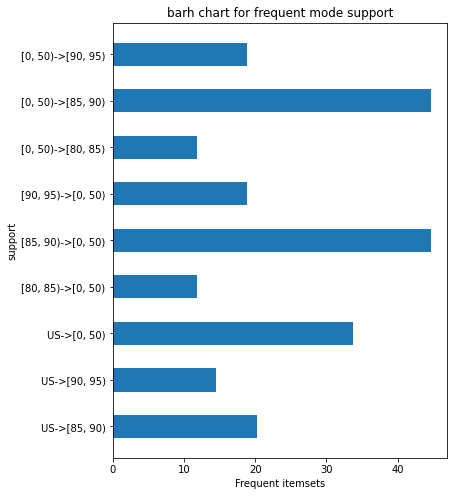

In [305]:
# 时间原因 其他结果一样的可视化 就可视化几个
plt.figure(figsize=(6, 8))
plt.barh(fp['item'],fp['support'], height=0.5)
plt.title('barh chart for frequent mode support')
plt.xlabel('Frequent itemsets')
plt.ylabel('support')

plt.show()


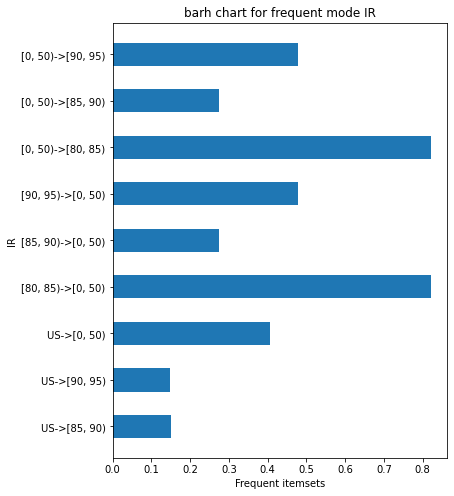

In [307]:
plt.figure(figsize=(6, 8))
plt.barh(fp['item'],fp['IR'], height=0.5)
plt.title('barh chart for frequent mode IR')
plt.xlabel('Frequent itemsets')
plt.ylabel('IR')

plt.show()

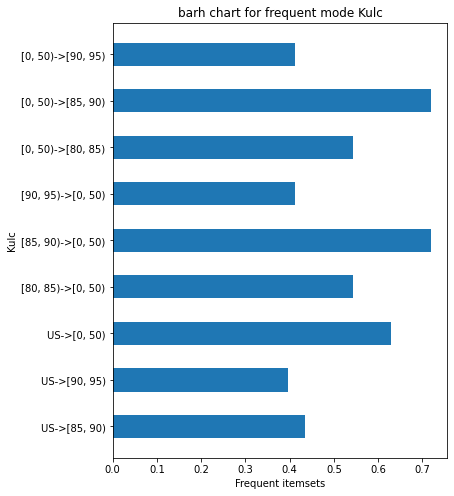

In [308]:
plt.figure(figsize=(6, 8))
plt.barh(fp['item'],fp['Kulc'], height=0.5)
plt.title('barh chart for frequent mode Kulc')
plt.xlabel('Frequent itemsets')
plt.ylabel('Kulc')

plt.show()

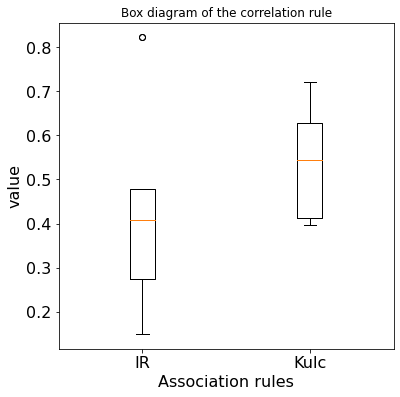

In [321]:
plt.figure(figsize=(6, 6))
box1,box2 = fp['IR'],fp['Kulc']
labels = 'IR','Kulc'
plt.boxplot([box1,box2],notch=False, labels = labels,patch_artist = False)
plt.xlabel("Association rules",fontsize=16)
plt.ylabel('value',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Box diagram of the correlation rule')
plt.show()